# Fitting an Einsum Network (Einet) on Synthetic 2D Data

In this tutorial, we'll go through the steps of fitting an Einsum Network (Einet) with a multivariate normal distribution on synthetic 2D data. We'll start by generating synthetic data, then initialize and train our Einet model, and finally visualize the results.

In [69]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

torch.manual_seed(1)
np.random.seed(1)

sns.set_style("whitegrid")

## Generating Synthetic Data

Next, we define a function to generate our synthetic 2D data. This data will be created from multiple anisotropic Gaussian distributions to provide a mix of points.

In [70]:
def generate_data(num_samples=100):
    # Parameters for first Gaussian blob
    mean1 = [2.0, 3.0]
    cov1 = [[1.0, 0.3], [0.3, 0.5]]

    # Parameters for second Gaussian blob
    mean2 = [-1.0, -2.0]
    cov2 = [[0.4, -0.1], [-0.1, 0.3]]

    # Parameters for third Gaussian blob
    mean3 = [4.0, -1.0]
    cov3 = [[0.3, 0.2], [0.2, 0.5]]

    # Parameters for fourth Gaussian blob
    mean4 = [-3.0, 2.0]
    cov4 = [[0.5, -0.2], [-0.2, 0.3]]

    # Generate data points
    data1 = np.random.multivariate_normal(mean1, cov1, num_samples // 4)
    data2 = np.random.multivariate_normal(mean2, cov2, num_samples // 4)
    data3 = np.random.multivariate_normal(mean3, cov3, num_samples // 4)
    data4 = np.random.multivariate_normal(mean4, cov4, num_samples // 4)
    data = np.vstack([data1, data2, data3, data4])

    return torch.tensor(data, dtype=torch.float32)

## Data Visualization

Visualizing our synthetic data helps us understand its structure and distribution.

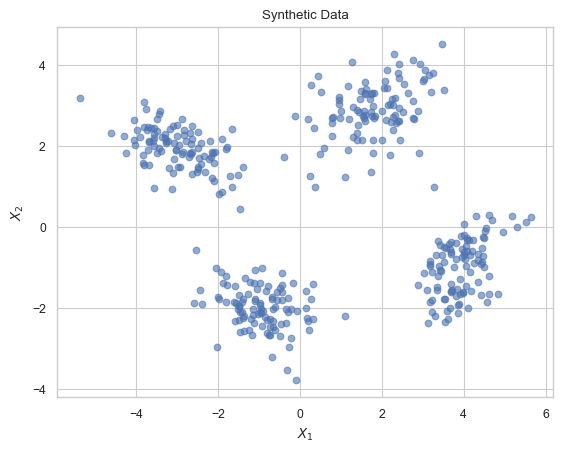

In [71]:
n_samples = 400
data = generate_data(n_samples)
plt.scatter(data[:, 0], data[:, 1], alpha=0.6)
plt.title("Synthetic Data")
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")
plt.show()

## Einet Model Initialization

We then proceed to configure and initialize our `Einet` model with the `EinetConfig` class.

In [72]:
from simple_einet.einet import Einet, EinetConfig
from simple_einet.layers.distributions.multivariate_normal import MultivariateNormal

# The model will be trained to fit the synthetic data
num_features = 2
num_channels = 1
num_leaves = 4
num_repetitions = 1
cardinality = 2

cfg = EinetConfig(
    num_features=num_features,
    num_channels=num_channels,
    num_leaves=num_leaves,
    depth=0,
    num_repetitions=num_repetitions,
    num_classes=1,
    leaf_type=MultivariateNormal,
    leaf_kwargs={"cardinality": cardinality},
)
model = Einet(cfg)
print(model)

Einet(
  EinetConfig(num_features=2, num_channels=1, num_sums=10, num_leaves=4, num_repetitions=1, num_classes=1, depth=0, dropout=0.0, leaf_type=<class 'simple_einet.layers.distributions.multivariate_normal.MultivariateNormal'>, leaf_kwargs={'cardinality': 2}, layer_type='linsum')
  (leaf): FactorizedLeaf(
    num_features=1, num_features_out=1
    (base_leaf): MultivariateNormal(num_features=2, num_leaves=4, out_shape=(N, 2, 4))
  )
  (layers): ModuleList(
    (0): SumLayer(num_features=1, num_sums_in=4, num_sums_out=1, num_repetitions=1, dropout=0.0, out_shape=(N, 1, 1, 1))
  )
)


## Training the Model

Using the Adam optimizer, we train our model on the synthetic data. We use the negative log-likelihood as our loss function, which is typical for probability density estimation tasks.

In [73]:
# Setup optimization
optimizer = optim.Adam(model.parameters(), lr=0.01)
epochs = 1000

# Training loop to fit the Multivariate Normal model
for epoch in range(epochs):
    optimizer.zero_grad()
    log_prob = model(data)

    # Negative log-likelihood as loss function
    loss = -torch.mean(log_prob)
    loss.backward()
    optimizer.step()

    # Logging to monitor progress
    if epoch % 100 == 99:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}")

Epoch [100/1000], Loss: 4.463514804840088
Epoch [200/1000], Loss: 4.042048931121826
Epoch [300/1000], Loss: 3.818615674972534
Epoch [400/1000], Loss: 3.6890697479248047
Epoch [500/1000], Loss: 3.4868271350860596
Epoch [600/1000], Loss: 3.2898919582366943
Epoch [700/1000], Loss: 3.2623250484466553
Epoch [800/1000], Loss: 3.255065679550171
Epoch [900/1000], Loss: 3.2535881996154785
Epoch [1000/1000], Loss: 3.2533926963806152


## Results Visualization

After training, we sample from the model and visualize these samples alongside our original data. We use seaborn to create density plots that show the distribution learned by the model.

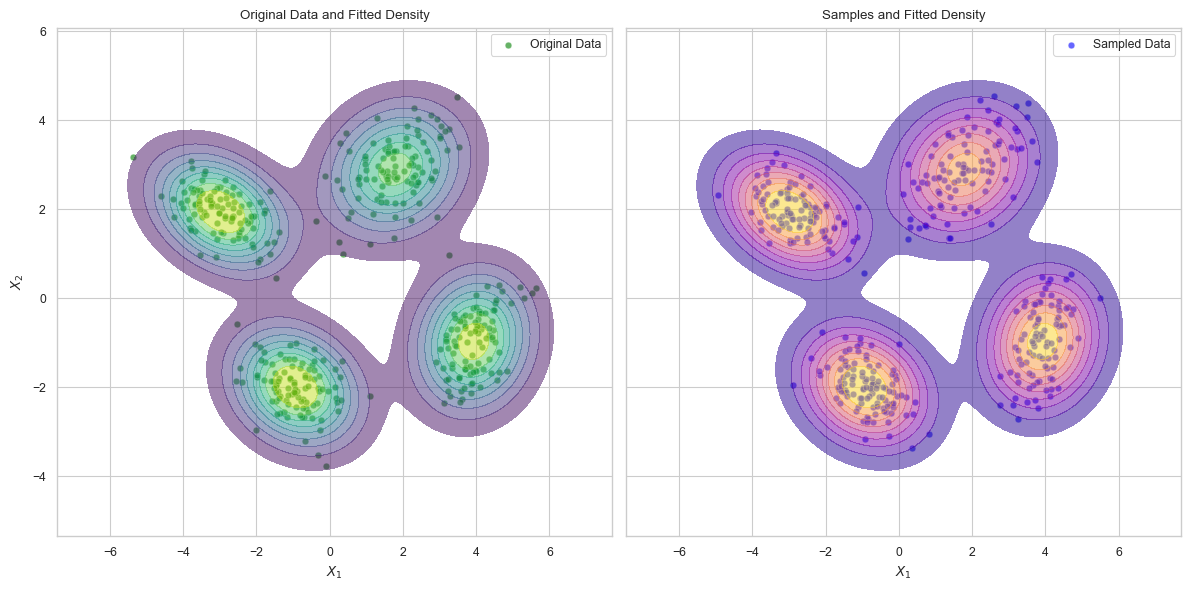

In [74]:
def plot_data_and_distribution_seaborn(data, samples, model):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

    # Generate a grid over which we evaluate the model's density function
    x, y = np.linspace(data[:, 0].min(), data[:, 0].max(), 100), np.linspace(
        data[:, 1].min(), data[:, 1].max(), 100
    )
    X, Y = np.meshgrid(x, y)
    grid = np.vstack([X.ravel(), Y.ravel()]).T

    # Evaluate the learned density function over the grid
    with torch.no_grad():
        grid_tensor = torch.tensor(grid, dtype=torch.float32)
        log_prob = model(grid_tensor)
        prob_density = log_prob.exp().numpy().ravel()  # Ensure this is 1-dimensional

    # Plot for original data points using Seaborn
    sns.scatterplot(x=data[:, 0], y=data[:, 1], ax=axes[0], color="green", alpha=0.6, label="Original Data")
    sns.kdeplot(x=grid[:, 0], y=grid[:, 1], weights=prob_density, fill=True, ax=axes[0], cmap="viridis", alpha=0.5)
    axes[0].set_title("Original Data and Fitted Density")
    axes[0].legend()
    axes[0].set_xlabel("$X_1$")
    axes[0].set_ylabel("$X_2$")

    # Plot for sampled data points using Seaborn
    sns.scatterplot(x=samples[:, 0], y=samples[:, 1], ax=axes[1], color="blue", alpha=0.6, label="Sampled Data")
    sns.kdeplot(x=grid[:, 0], y=grid[:, 1], weights=prob_density, fill=True, ax=axes[1], cmap="plasma", alpha=0.5)
    axes[1].set_title("Samples and Fitted Density")
    axes[1].legend()
    axes[1].set_xlabel("$X_1$")
    axes[1].set_ylabel("$X_2$")

    plt.tight_layout()
    plt.show()
    
# Sample
samples = model.sample(num_samples=n_samples)
samples.squeeze_(1)

plot_data_and_distribution_seaborn(data, samples, model)
